# ACSE-8
## Coursework 2 - Training a classifier on CIFAR10

You task in this coursework is to implement, train and validate a classifier on the CIFAR10 dataset.  
You are free to use the code provided previously in the classroom exercises - but that code will need to be adapted to work on CIFAR10. 

Complete the following tasks:

1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)
2. Plot 25 images of the training set together with their corresponding label names. (1 point)
3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)
4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validat|ion and test data. (1 point)
5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)
6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]```
7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).
8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).
9. Answer the following questions (1 point each):   
  **Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees

10. Bonus: Once you are certain you have achieved all points in the above excercise!
  - Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)
  - Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)
  
 Describe your working as comments in a Jupyter Notebook together with your code implementation and provide the final Jupyter Notebook and your trained model weights in a github repository.
 
 Total Points: 23 (+7 Bonus Points)

**SET-UP**

In [1]:
# ipython setup
!pip install pycm livelossplot torchvision
%pylab inline

     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 542kB 18.4MB/s 
Populating the interactive namespace from numpy and matplotlib


In [0]:
#Library imports 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import matplotlib.pyplot as plt


In [0]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ## uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
    torch.backends.cudnn.enabled   = False  ## does not enable the inbuilt cudnn deep learning library for training neural networks

    return True

In [4]:
# checking if GPU is avaliable 
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available(): ## run on GPUs if available
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")


Cuda installed! Running on GPU!


In [5]:
# mounting google drive for later storage
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)**

***

In [46]:
cifar10_train = CIFAR10("./", download=True, train=True) ## download the training data to the curernt working directory
cifar10_test = CIFAR10("./", download=True, train=False) ## download the test data to the curernt working directory


Files already downloaded and verified
Files already downloaded and verified


**2. Plot 25 images of the training set together with their corresponding label names. (1 point)**

***

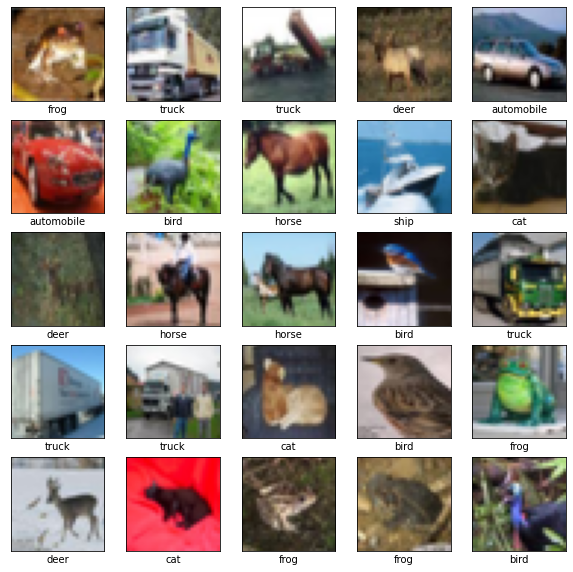

In [7]:
# pick 25 images and plot
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#setup the figure 
plt.figure(figsize=(10,10))
#request 5x5=25 first images 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_train[i][0])
    plt.xlabel(class_names[cifar10_train[i][1]])
plt.show()

**3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)**

***

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(cifar10_train.data, cifar10_train.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

**4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data. (1 point)**

***

In [9]:
# use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(cifar10_train[i][0]) for i in range(len(cifar10_train))])
print("size:", x.shape)

# calculate the mean and std along the (0, 1) axes
# also normalize pixel values to the range 0 to 1 by dividing by 255 
means = np.mean(x, axis=(0, 1))/255
stds = np.std(x, axis=(0, 1))/255

# the the mean and std
print("mean: ", means, "avg:", np.mean(means))
print("std: ", stds, "avg:", np.mean(stds))


size: (1600000, 32, 3)
mean:  [0.49139968 0.48215841 0.44653091] avg: 0.4733630004850899
std:  [0.24703223 0.24348513 0.26158784] avg: 0.250701734063764


In [0]:
def apply_normalization(X):
  X = X / 255.
  X = X - 0.473363 ## mean of the pixel values in this data set is 0.4733630004850899
  X = X / (0.250702**0.5) ## variance of the pixel values in this dataset is 0.250701734063764 square root
  return X

In [0]:
X_train, y_train = apply_normalization(cifar10_train.data[indices[0]]), np.array(cifar10_train.targets)[indices[0]]
X_val, y_val = apply_normalization(cifar10_train.data[indices[1]]), np.array(cifar10_train.targets)[indices[1]]
X_test, y_test =  apply_normalization(cifar10_test.data), np.array(cifar10_test.targets)

In [0]:
cifar10_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
cifar10_validate = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val).long())
cifar10_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


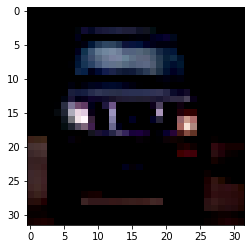

In [13]:
#Visualise an example of the images for sanity check
plt.imshow(X_train[0])
# compute .mean() and .std() on the training set
#print(X_train.mean(), X_train.std())

**5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)**

***

In [14]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = F.dropout(x, p = 0.02 , training = self.training)
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = F.dropout(x, p = 0.02 , training = self.training )
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
    
x = torch.randn((1, 3, 32, 32))
model = LeNet5()
y = model(x)
print(y) 


tensor([[ 0.0621, -0.1878,  0.0656, -0.0759,  0.1142,  0.1212,  0.0226,  0.2078,
         -0.1359, -0.0583]], grad_fn=<AddmmBackward>)


In [0]:
# Provided Train, Validation and Evaluate functions

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.permute(0,3,1,2))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.permute(0,3,1,2))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.permute(0,3,1,2))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

**6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).**
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]``` 

***


In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30
weight_decay = [0.0, 1e-3, 1e-4, 1e-5]

In [0]:
def train_model(weight):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(cifar10_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(cifar10_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
  return model

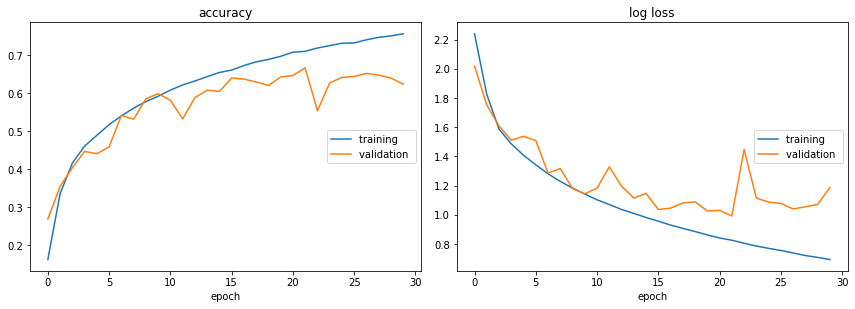

accuracy
	training         	 (min:    0.162, max:    0.756, cur:    0.756)
	validation       	 (min:    0.269, max:    0.666, cur:    0.623)
log loss
	training         	 (min:    0.694, max:    2.239, cur:    0.694)
	validation       	 (min:    0.991, max:    2.018, cur:    1.187)


In [19]:
# weight decay 0 
# this is choosen as the best weight decay value 
model_1 = train_model(weight_decay[0])

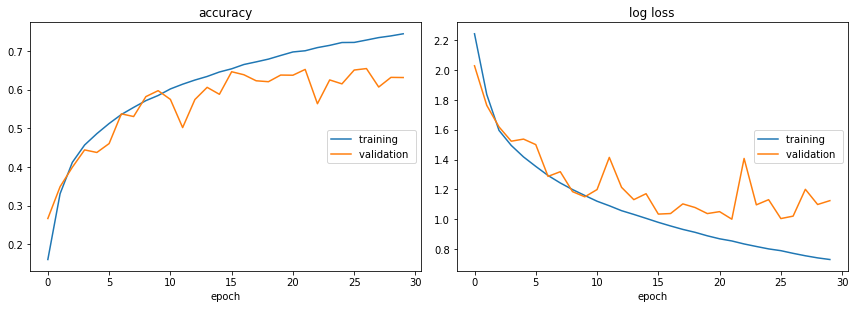

accuracy
	training         	 (min:    0.160, max:    0.756, cur:    0.745)
	validation       	 (min:    0.266, max:    0.666, cur:    0.631)
log loss
	training         	 (min:    0.694, max:    2.243, cur:    0.729)
	validation       	 (min:    0.991, max:    2.028, cur:    1.124)


In [20]:
#weight decay 1e-3
model_2 = train_model(weight_decay[1])

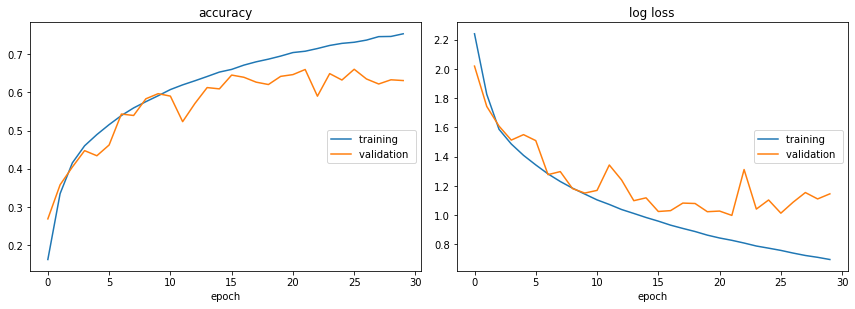

accuracy
	training         	 (min:    0.160, max:    0.756, cur:    0.754)
	validation       	 (min:    0.266, max:    0.666, cur:    0.631)
log loss
	training         	 (min:    0.694, max:    2.243, cur:    0.697)
	validation       	 (min:    0.991, max:    2.028, cur:    1.146)


In [21]:
#weight decay 1e-4
model_3 = train_model(weight_decay[2])

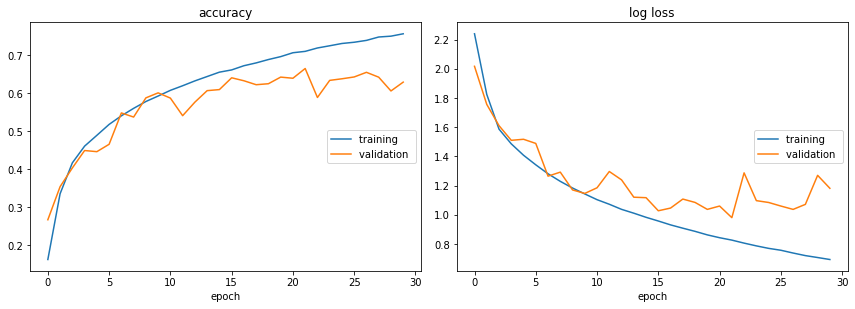

accuracy
	training         	 (min:    0.160, max:    0.756, cur:    0.756)
	validation       	 (min:    0.266, max:    0.666, cur:    0.629)
log loss
	training         	 (min:    0.694, max:    2.243, cur:    0.694)
	validation       	 (min:    0.980, max:    2.028, cur:    1.181)


In [22]:
# weight decay 1e-5
model_4 = train_model(weight_decay[3])

**7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).**

***

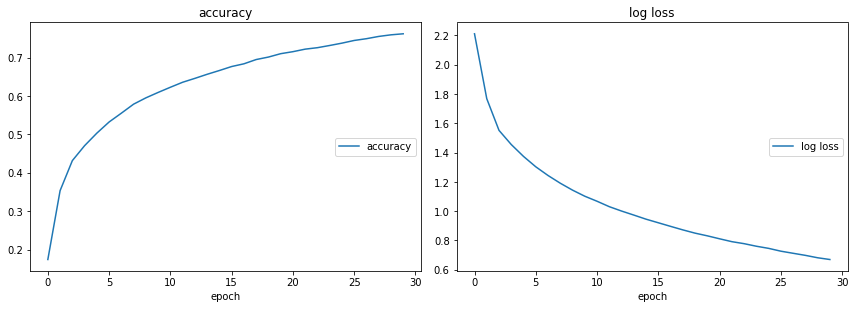

accuracy
	accuracy         	 (min:    0.174, max:    0.762, cur:    0.762)
log loss
	log loss         	 (min:    0.669, max:    2.211, cur:    0.669)


In [23]:
cifar10_train = CIFAR10("./", download=True, train=True)

X_train, y_train = apply_normalization(cifar10_train.data), cifar10_train.targets
cifar10_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= 0)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

**8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).**

***

In [24]:
validation_loader = DataLoader(cifar10_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(cifar10_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.989  Avg. Test Accuracy: 0.672



In [32]:
model_save_name = 'VA_LeNet5_cifar10_classifier.pth'
path =  F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)
print("Successfully Stored")


Successfully Stored


**9. Answer the following questions (1 point each):   
  Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?**

➕ indicates reasonable

➖ indicates not reasonable

➕➖ indicates uncertainty 

***

➕ **Left-Right Flips**

For all the classes in the dataset, there will not be a major difference between left or right. For example, when horse is flipped horizontally it will still maintain its main features hence the network should be able to identfy it.

➕**Random Rotations by up to 10 Degrees**

The subject of the image will not change due to the minor changes in the inclinations. Also, natively we can not assume that all the images are perfectly horizontal thus various inclinations should be inherit in the data to begin with. However, CIFAR-10 has low dimension of 32x32 which might not benefit fully from this.

➖**Up-Down Flips**

In the previous case of left-right flip, there is no major difference for details however in this case there is. In practice, a human can still identify an upside down bird however even in nature this is usually not a common sight. Also, the positioning of certain features are significant in images. Such as cars having their wheels at the bottom and not the top. Requiring your network to recognize such flipped images will demand more data to be trained efficiently. The normal performace might be hindered as well since the nuerons are being restricted by symmetry. 

The use of this augmentation is only apparent when the neural network has to recognize flipped objects. However, in most scenarios there is no need to for example recognize a up-side down horse as the occurrence of this happing is low (it is an outlier).

➕**Shifting up-down, left-right by 5 pixels**

A shifted image will still maintain the same object. This kind of shifting can result in the object not being fully visible, certain features not present. However, the network should still be able to identfy the object with the avalibale key features. However, 5 pixels might be too much due to the size of the data. Hence, try somthing smaller such as 3 pixels.

➕➖ **Contrast Changes**

Contrast changes can be thought of as altering the lighting of the image. Hence, what is being looked at is not majorly changed, the main features remain unaltered. However, playing around with it too much can make it unrecognisable to humans thus it should be approached with caution.

➕➖**Adding Gaussian Noise**

The noise might end up hiding some of the features, making it less noticable. Hence, caution must be taken that not too much is lost in the noise generated.

➖**Random Rotations by up to 90 Degrees**

This is not reasanoble due to the same thinking used for the up-down flip. 

Such rotation will change the relative position of the features excesivelly, thus requiring the nueral network to become more complex to recognise the features in the image than it has to. 

Hence, it comes down whether the network is being asked to recognize sideway cars.


**10. Bonus: Once you are certain you have achieved all points in the above excercise!**
  - Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)

*Available Datasets converted to a more custom functionality*

In [0]:
from torch.utils.data import Dataset 
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.permute(2,0,1).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
# Provided Train, Validation and Evaluate functions
# deleting permute here to avoid using it twice 
def cs_train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def cs_validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def cs_evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

*Transforms can be used to perform manipulation of individual data prior to passing the data to our models. Essential for Data-augmentation*

In [0]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomHorizontalFlip, RandomCrop, RandomGrayscale

#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform_flip = Compose([
    ToPILImage(),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    Normalize(mean=[0.473363], std=[0.250702]), 
]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

train_transform_crop = Compose([
    ToPILImage(),
    RandomCrop(32, padding = 3),
    ToTensor(),
    Normalize(mean=[0.473363], std=[0.250702]), 
])

train_transform_gray = Compose([
    ToPILImage(),
    RandomGrayscale(0.5),
    ToTensor(),
    Normalize(mean=[0.473363], std=[0.250702]), 
])

train_transform = Compose([
    ToPILImage(),
    RandomHorizontalFlip(0.5),
    RandomCrop(32, padding = 3),
    ToTensor(),
    Normalize(mean=[0.473363], std=[0.250702]), 
])


#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=[0.473363], std=[0.250702])
])

In [56]:
#creating the CustomImageTensorDataset
cifar10_train = CIFAR10("./", download=True, train=True)
X_train, y_train = cifar10_train.data, cifar10_train.targets

cifar10_test = CIFAR10("./", download=True, train=False)
X_test, y_test = cifar10_test.data, cifar10_test.targets

custom_cifar10_train = CustomImageTensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long(), transform=train_transform)
cifar10_test = CustomImageTensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long(), transform=validation_test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = cs_train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = cs_validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
  return model


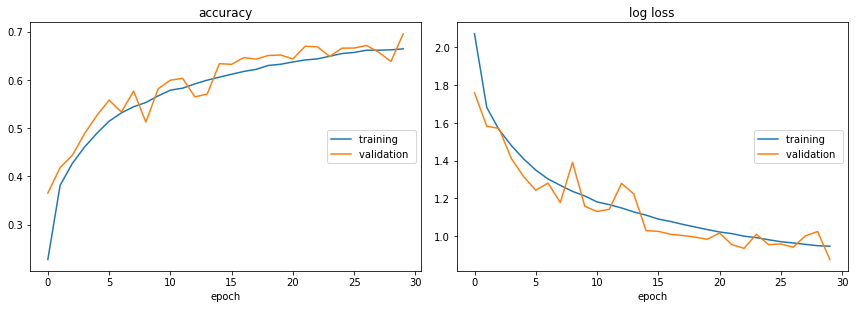

accuracy
	training         	 (min:    0.160, max:    0.756, cur:    0.664)
	validation       	 (min:    0.266, max:    0.695, cur:    0.695)
log loss
	training         	 (min:    0.694, max:    2.243, cur:    0.948)
	validation       	 (min:    0.877, max:    2.028, cur:    0.877)


In [58]:
model = train_model_augmented(custom_cifar10_train, cifar10_test)

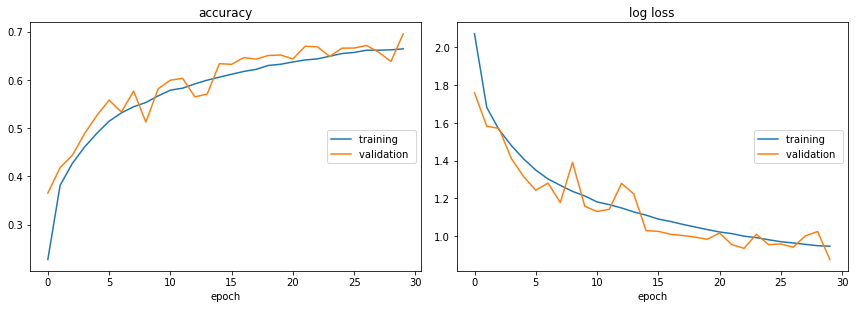

accuracy
	training         	 (min:    0.160, max:    0.756, cur:    0.664)
	validation       	 (min:    0.266, max:    0.695, cur:    0.695)
log loss
	training         	 (min:    0.694, max:    2.243, cur:    0.948)
	validation       	 (min:    0.877, max:    2.028, cur:    0.877)


In [59]:
train_loader = DataLoader(custom_cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=test_batch_size, shuffle=False, num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = cs_train(model, optimizer, criterion, train_loader)
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = cs_validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()


In [60]:
test_loss, test_accuracy = cs_validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.877  Avg. Test Accuracy: 0.695



In [61]:
model_save_name = 'VA_LeNet5_AUG_cifar10_classifier.pth'
path =  F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)
print("Successfully Stored")


Successfully Stored


**Result:** The Avg Test Accuracy went from 0.672 to 0.695

  - Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(3,   64,  3)
        self.c2 = nn.Conv2d(64,  128, 3)
        self.c3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.f1 = nn.Linear(64 * 4 * 4, 128)
        self.f2 = nn.Linear(128, 256)
        self.f3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = self.pool(F.relu(self.c3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = self.f3(x)
        return F.log_softmax(x, dim=1)

x = torch.randn((1, 3, 32, 32))
model = CNN()
y = model(x)
print(y) 

tensor([[-2.2331, -2.3482, -2.2735, -2.3573, -2.3199, -2.2733, -2.2976, -2.3378,
         -2.2920, -2.3000]], grad_fn=<LogSoftmaxBackward>)


In [63]:
cifar10_train = CIFAR10("./", download=True, train=True)
X_train, y_train = cifar10_train.data, cifar10_train.targets

cifar10_test = CIFAR10("./", download=True, train=False)
X_test, y_test = cifar10_test.data, cifar10_test.targets

custom_cifar10_train = CustomImageTensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long(), transform=train_transform)
cifar10_test = CustomImageTensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long(), transform=validation_test_transform)

train_loader = DataLoader(custom_cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=test_batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


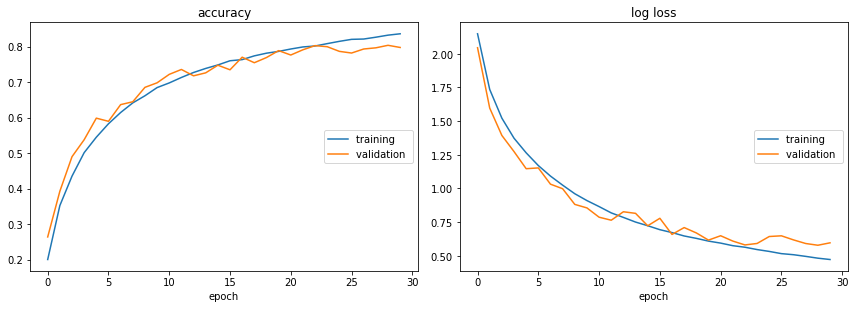

accuracy
	training         	 (min:    0.160, max:    0.836, cur:    0.836)
	validation       	 (min:    0.264, max:    0.804, cur:    0.798)
log loss
	training         	 (min:    0.473, max:    2.243, cur:    0.473)
	validation       	 (min:    0.579, max:    2.045, cur:    0.597)


In [64]:
train_loader = DataLoader(custom_cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=test_batch_size, shuffle=False, num_workers=4)

set_seed(seed)
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = cs_train(model, optimizer, criterion, train_loader)
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = cs_validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()

In [65]:
test_loss, test_accuracy = cs_validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.597  Avg. Test Accuracy: 0.798



In [66]:
model_save_name = 'VA_CNN_cifar10_classifier.pth'
path =  F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)
print("Successfully Stored")


Successfully Stored
